# Initial exploration of the problem

## Setup

In [1]:
# load libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import keras

## Inspect dataset

In [2]:
# load data
df = pd.read_csv("Sentiment_Analysis.csv")
df.head()

,tweet_id,sentiment,author,content
0,1956967341,empty,xoshayzers,@tiffanylue i know i was listenin to bad habi...
1,1956967666,sadness,wannamama,Layin n bed with a headache ughhhh...waitin o...
2,1956967696,sadness,coolfunky,Funeral ceremony...gloomy friday...
3,1956967789,enthusiasm,czareaquino,wants to hang out with friends SOON!
4,1956968416,neutral,xkilljoyx,@dannycastillo We want to trade with someone w...


In [3]:
# basic dataset information
print(f"{df.shape[0]} observations")

40000 observations


sentiment
neutral       0.216
worry         0.211
happiness     0.130
sadness       0.129
love          0.096
surprise      0.055
fun           0.044
relief        0.038
hate          0.033
empty         0.021
enthusiasm    0.019
boredom       0.004
anger         0.003
Name: proportion, dtype: float64 
13 classes


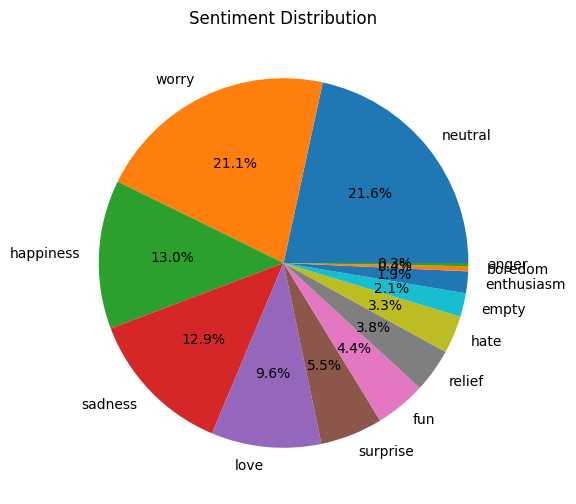

In [4]:
# inspect class distribution
sentiment_dist = df['sentiment'].value_counts(normalize=True)
print(sentiment_dist.round(3), f"\n{len(sentiment_dist)} classes")

# pie chart
plt.figure(figsize=(10, 6))
plt.pie(sentiment_dist.values, labels=sentiment_dist.index, autopct='%1.1f%%')
plt.title('Sentiment Distribution')
plt.show()

## Data split

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# encode labels
le = LabelEncoder()
y = le.fit_transform(df['sentiment'])

# first split (train + val, test)
X_temp, X_test, y_temp, y_test = train_test_split(
    df['content'].values,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

# second split (train, val)
X_train, X_val, y_train, y_val = train_test_split(
    X_temp,
    y_temp,
    test_size=0.25,
    random_state=42,
    stratify=y_temp
)

print(f"Training set: {len(X_train)} samples")
print(f"Validation set: {len(X_val)} samples")
print(f"Test set: {len(X_test)} samples")

Training set: 24000 samples
Validation set: 8000 samples
Test set: 8000 samples


## Sentence and word embeddings

In [6]:
from sentence_transformers import SentenceTransformer

# maybe could try other models here later
embedding_model = SentenceTransformer("all-MiniLM-L6-v2")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [7]:
# generate sentence embeddings

X_train_emb = embedding_model.encode(
    X_train,
    show_progress_bar=True,
    convert_to_numpy=True
)

X_val_emb = embedding_model.encode(
    X_val,
    show_progress_bar=True,
    convert_to_numpy=True
)

X_test_emb = embedding_model.encode(
    X_test,
    show_progress_bar=True,
    convert_to_numpy=True
)

print(f"Training embeddings shape: {X_train_emb.shape}")
print(f"Validation embeddings shape: {X_val_emb.shape}")
print(f"Test embeddings shape: {X_test_emb.shape}")

Batches:   0%|          | 0/750 [00:00<?, ?it/s]

Batches:   0%|          | 0/250 [00:00<?, ?it/s]

Batches:   0%|          | 0/250 [00:00<?, ?it/s]

Training embeddings shape: (24000, 384)
Validation embeddings shape: (8000, 384)
Test embeddings shape: (8000, 384)


In [8]:
import nltk
nltk.download('punkt_tab')
from nltk.tokenize import word_tokenize
word_tokenize('hello world!')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


['hello', 'world', '!']

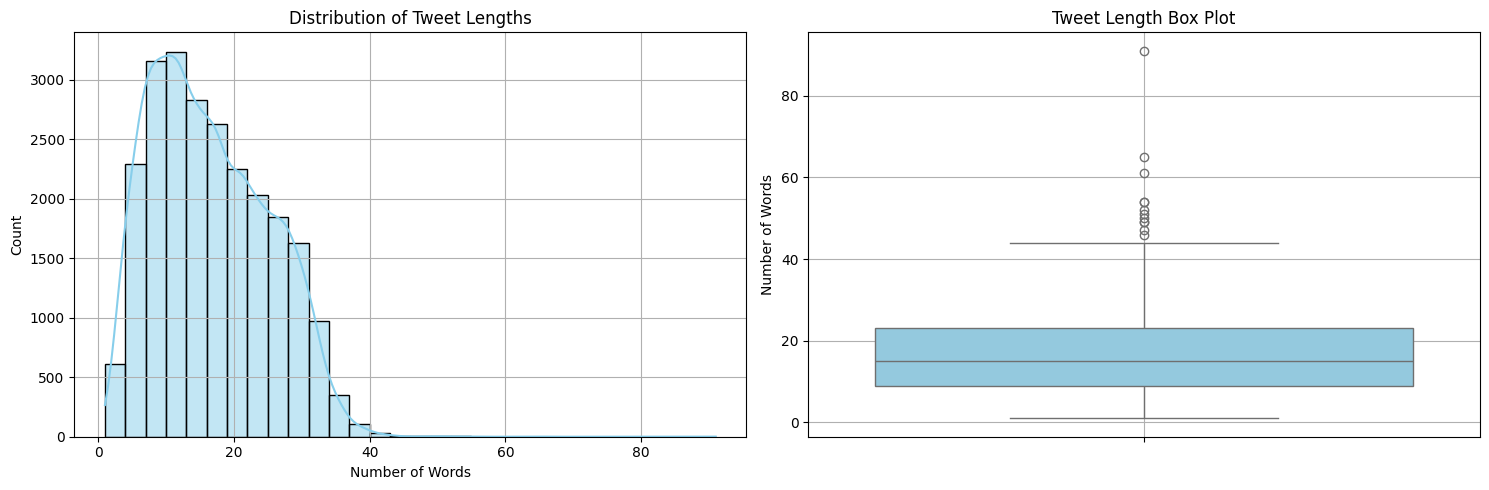


Tweet Length Statistics:
Minimum length: 1 words
Maximum length: 91 words
Mean length: 16.5 words
Median length: 15 words

Percentiles:
10th percentile: 6.0 words
25th percentile: 9.0 words
75th percentile: 23.0 words
90th percentile: 29.0 words
95th percentile: 31.0 words

Tweets longer than 20 words: 7778 (32.4%)

Tweets longer than 30 words: 1482 (6.2%)

Tweets longer than 40 words: 36 (0.1%)

Tweets longer than 50 words: 7 (0.0%)


In [9]:
# tweet length distribution
tweet_lengths = [len(word_tokenize(text)) for text in X_train]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Plot 1: Histogram with KDE
sns.histplot(tweet_lengths, bins=30, kde=True, color='skyblue', ax=ax1)
ax1.set_title('Distribution of Tweet Lengths')
ax1.set_xlabel('Number of Words')
ax1.set_ylabel('Count')
ax1.grid(True)

# Plot 2: Box plot
sns.boxplot(y=tweet_lengths, color='skyblue', ax=ax2)
ax2.set_title('Tweet Length Box Plot')
ax2.set_ylabel('Number of Words')
ax2.grid(True)

plt.tight_layout()
plt.show()

# Print statistical summary
print("\nTweet Length Statistics:")
print(f"Minimum length: {min(tweet_lengths)} words")
print(f"Maximum length: {max(tweet_lengths)} words")
print(f"Mean length: {sum(tweet_lengths)/len(tweet_lengths):.1f} words")
print(f"Median length: {sorted(tweet_lengths)[len(tweet_lengths)//2]} words")
print(f"\nPercentiles:")
for p in [10, 25, 75, 90, 95]:
    percentile = np.percentile(tweet_lengths, p)
    print(f"{p}th percentile: {percentile:.1f} words")

# Calculate how many tweets would be affected by different max lengths
for max_len in [20, 30, 40, 50]:
    affected = sum(1 for x in tweet_lengths if x > max_len)
    print(f"\nTweets longer than {max_len} words: {affected} ({affected/len(tweet_lengths):.1%})")

In [10]:
# Tokenization and padding function for sequences
from tensorflow.keras.preprocessing.sequence import pad_sequences

def process_text_sequences(texts, max_length=40, padding='post', truncating='post'):
    """
    Convert texts to padded sequences of tokens.

    Args:
        texts: List of text strings
        max_length: Maximum sequence length (default: 40)
        padding: 'pre' or 'post' padding (default: 'post')
        truncating: 'pre' or 'post' truncation (default: 'post')

    Returns:
        List of padded token sequences
    """
    # Tokenize all texts
    sequences = [word_tokenize(text) for text in texts]

    # Convert tokens to numpy arrays with padding
    padded_sequences = pad_sequences(
        sequences=[s[:max_length] for s in sequences],  # Truncate if needed
        maxlen=max_length,
        padding=padding,
        truncating=truncating,
        dtype=object,  # Use object dtype for string tokens
        value=''  # Use empty string as padding token
    )

    return padded_sequences

# Process training, validation, and test sets
print("Processing sequences...")
X_train_padded = process_text_sequences(X_train)
X_val_padded = process_text_sequences(X_val)
X_test_padded = process_text_sequences(X_test)

# Print shapes and example
print(f"\nSequence shapes:")
print(f"Training: {X_train_padded.shape}")
print(f"Validation: {X_val_padded.shape}")
print(f"Test: {X_test_padded.shape}")

# Show an example sequence
print("\nExample padded sequence:")
print(X_train_padded[1])

Processing sequences...

Sequence shapes:
Training: (24000, 40)
Validation: (8000, 40)
Test: (8000, 40)

Example padded sequence:
['Twitter' 'has' 'spoiled' 'all' 'the' 'fun' '.' 'Frustratingly' 'slow'
 '!' '!' 'couldnt' 'even' 'bid' 'properly' '!' '' '' '' '' '' '' '' '' ''
 '' '' '' '' '' '' '' '' '' '' '' '' '' '' '']


In [11]:
from functools import cache
@cache
def encode_words(text):
    return embedding_model.encode(text)

In [12]:
%%time
# Convert padded sequences to embeddings
def create_embedding_sequences(sequences, max_length=40):
    """
    Convert sequences of words to sequences of embeddings using cached word vectors.
    Ensures all sequences have the same length through padding.

    Args:
        sequences: List of word sequences (padded)
        max_length: Maximum sequence length (default: 40)
    Returns:
        numpy array of shape (n_sequences, max_length, embedding_dim)
    """
    n_sequences = len(sequences)
    embedding_dim = 384  # Known dimension from the model

    # Initialize the output array with zeros
    embedded_seqs = np.zeros((n_sequences, max_length, embedding_dim))

    for i, seq in enumerate(sequences):
        # Get embeddings for non-empty tokens
        valid_tokens = [word for word in seq if word != '']
        # Truncate if necessary
        valid_tokens = valid_tokens[:max_length]
        # Create embeddings for valid tokens
        seq_embeddings = [encode_words(word) for word in valid_tokens]

        # Add embeddings to the output array with padding
        for j, embedding in enumerate(seq_embeddings):
            if j < max_length:
                embedded_seqs[i, j] = embedding

    return embedded_seqs

# Create embeddings for each split
print("Creating word embeddings for training set...")
X_train_embedded = create_embedding_sequences(X_train_padded)
print("Creating word embeddings for validation set...")
X_val_embedded = create_embedding_sequences(X_val_padded)
print("Creating word embeddings for test set...")
X_test_embedded = create_embedding_sequences(X_test_padded)

print("\nEmbedding shapes:")
print(f"Training: {X_train_embedded.shape}")
print(f"Validation: {X_val_embedded.shape}")
print(f"Test: {X_test_embedded.shape}")

Creating word embeddings for training set...
Creating word embeddings for validation set...
Creating word embeddings for test set...

Embedding shapes:
Training: (24000, 40, 384)
Validation: (8000, 40, 384)
Test: (8000, 40, 384)
CPU times: user 5min 41s, sys: 1.5 s, total: 5min 43s
Wall time: 5min 46s


## Basic models

In [13]:
# setup PyTorch backend
import os
os.environ['KERAS_BACKEND'] = 'torch'
import torch
print("Using PyTorch backend")
device = 'cuda' if torch.cuda.is_available() else 'cpu'

print(f"Using device: {device}")

Using PyTorch backend
Using device: cuda


In [14]:
from keras.layers import Dense
from keras.models import Sequential

# mlp
mlp_model = Sequential([
    Dense(10, activation='relu', input_shape=(384,)),
    Dense(10, activation='relu'),
    Dense(10, activation='relu'),
    Dense(13, activation='softmax')
])

mlp_model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

mlp_model.summary()

mlp_history = mlp_model.fit(X_train_emb, y_train, validation_data=(X_val_emb, y_val), epochs=10)

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 10)             │         3,850 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │           110 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 10)             │           110 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 13)             │           143 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,213 (16.46 KB)

 Trainable params: 4,213 (16.46 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.2118 - loss: 2.2805 - val_accuracy: 0.3225 - val_loss: 1.9782
Epoch 2/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.3290 - loss: 1.9489 - val_accuracy: 0.3435 - val_loss: 1.8970
Epoch 3/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.3426 - loss: 1.8989 - val_accuracy: 0.3476 - val_loss: 1.8812
Epoch 4/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.3523 - loss: 1.8743 - val_accuracy: 0.3568 - val_loss: 1.8758
Epoch 5/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.3619 - loss: 1.8643 - val_accuracy: 0.3568 - val_loss: 1.8656
Epoch 6/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.3710 - loss: 1.8496 - val_accuracy: 0.3576 - val_loss: 1.8619
Epoch 7/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.3717 - loss: 1.8406 - val_accuracy: 0.3587 - val_loss: 1.8618
Epoch 8/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.3803 - loss: 1.8224 - val_accuracy: 0.

In [15]:
import xgboost as xgb

# xgboost
xgb_model = xgb.XGBClassifier(n_estimators=500, learning_rate=0.1, max_depth=5, early_stopping_rounds=5)
xgb_model.fit(X_train_emb, y_train, eval_set=[(X_val_emb, y_val)], verbose=5)

[0]	validation_0-mlogloss:2.44591
[5]	validation_0-mlogloss:2.26002
[10]	validation_0-mlogloss:2.15241
[15]	validation_0-mlogloss:2.08448
[20]	validation_0-mlogloss:2.03847
[25]	validation_0-mlogloss:2.00531
[30]	validation_0-mlogloss:1.98189
[35]	validation_0-mlogloss:1.96360
[40]	validation_0-mlogloss:1.94896
[45]	validation_0-mlogloss:1.93879
[50]	validation_0-mlogloss:1.93109
[55]	validation_0-mlogloss:1.92451
[60]	validation_0-mlogloss:1.91879
[65]	validation_0-mlogloss:1.91427
[70]	validation_0-mlogloss:1.91038
[75]	validation_0-mlogloss:1.90793
[80]	validation_0-mlogloss:1.90560
[85]	validation_0-mlogloss:1.90421
[90]	validation_0-mlogloss:1.90260
[95]	validation_0-mlogloss:1.90169
[100]	validation_0-mlogloss:1.90115
[105]	validation_0-mlogloss:1.90022
[110]	validation_0-mlogloss:1.90020
[115]	validation_0-mlogloss:1.90000
[120]	validation_0-mlogloss:1.90006
[122]	validation_0-mlogloss:1.90027


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=5,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=500,
              n_jobs=None, num_parallel_tree=None, ...)

In [16]:
from keras.layers import SimpleRNN

# vanilla rnn
rnn_model = Sequential([
    SimpleRNN(16, input_shape=(40, 384)),
    Dense(15, activation='relu'),
    Dense(13, activation='softmax')
])

rnn_model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

rnn_model.summary()

rnn_history = rnn_model.fit(X_train_embedded, y_train, validation_data=(X_val_embedded, y_val), epochs=10)

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn (SimpleRNN)          │ (None, 16)             │         6,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 15)             │           255 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 13)             │           208 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,879 (26.87 KB)

 Trainable params: 6,879 (26.87 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.2068 - loss: 2.2563 - val_accuracy: 0.2160 - val_loss: 2.1464
Epoch 2/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.2193 - loss: 2.1410 - val_accuracy: 0.2160 - val_loss: 2.1472
Epoch 3/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.2218 - loss: 2.1467 - val_accuracy: 0.2115 - val_loss: 2.1491
Epoch 4/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.2111 - loss: 2.1506 - val_accuracy: 0.2114 - val_loss: 2.1471
Epoch 5/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.2126 - loss: 2.1464 - val_accuracy: 0.2161 - val_loss: 2.1456
Epoch 6/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.2137 - loss: 2.1335 - val_accuracy: 0.2165 - val_loss: 2.1479
Epoch 7/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.2121 - loss: 2.1447 - val_accuracy: 0.2163 - val_loss: 2.1471
Epoch 8/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.2162 - loss: 2.1463 - val_accuracy: 

In [17]:
from keras.layers import LSTM, LayerNormalization

# lstm
lstm_model = Sequential([
    LSTM(16, input_shape=(40, 384)),
    LayerNormalization(),
    Dense(15, activation='relu'),
    Dense(13, activation='softmax')
])

lstm_model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

lstm_model.summary()

lstm_history = lstm_model.fit(X_train_embedded, y_train, validation_data=(X_val_embedded, y_val), epochs=10)

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 16)             │        25,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_normalization             │ (None, 16)             │            32 │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 15)             │           255 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 13)             │           208 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 26,159 (102.18 KB)

 Trainable params: 26,159 (102.18 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 13s 10ms/step - accuracy: 0.2164 - loss: 2.2180 - val_accuracy: 0.2648 - val_loss: 2.1018
Epoch 2/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - accuracy: 0.3038 - loss: 2.0325 - val_accuracy: 0.3339 - val_loss: 1.9535
Epoch 3/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - accuracy: 0.3313 - loss: 1.9353 - val_accuracy: 0.3420 - val_loss: 1.9261
Epoch 4/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.3424 - loss: 1.9149 - val_accuracy: 0.3453 - val_loss: 1.9072
Epoch 5/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - accuracy: 0.3477 - loss: 1.8945 - val_accuracy: 0.3331 - val_loss: 1.9131
Epoch 6/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.3477 - loss: 1.8936 - val_accuracy: 0.3471 - val_loss: 1.9011
Epoch 7/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - accuracy: 0.3575 - loss: 1.8775 - val_accuracy: 0.3397 - val_loss: 1.9059
Epoch 8/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.3623 - loss: 1.8646 - val_accuracy:

In [18]:
from keras.layers import GRU

# gru
gru_model = Sequential([
    GRU(16, input_shape=(40, 384)),
    Dense(15, activation='relu'),
    Dense(13, activation='softmax')
])


gru_model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

gru_model.summary()

gru_history = gru_model.fit(X_train_embedded, y_train, validation_data=(X_val_embedded, y_val), epochs=10)

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru (GRU)                       │ (None, 16)             │        19,296 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 15)             │           255 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 13)             │           208 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,759 (77.18 KB)

 Trainable params: 19,759 (77.18 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - accuracy: 0.1964 - loss: 2.2411 - val_accuracy: 0.2163 - val_loss: 2.1451
Epoch 2/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.2222 - loss: 2.1426 - val_accuracy: 0.2118 - val_loss: 2.1410
Epoch 3/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.2308 - loss: 2.1359 - val_accuracy: 0.2970 - val_loss: 2.0306
Epoch 4/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.2970 - loss: 1.9960 - val_accuracy: 0.3232 - val_loss: 1.9486
Epoch 5/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.3297 - loss: 1.9373 - val_accuracy: 0.3478 - val_loss: 1.9122
Epoch 6/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - accuracy: 0.3441 - loss: 1.8891 - val_accuracy: 0.3562 - val_loss: 1.8894
Epoch 7/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.3533 - loss: 1.8729 - val_accuracy: 0.3487 - val_loss: 1.8865
Epoch 8/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.3583 - loss: 1.8624 - val_accuracy: 0